In [64]:
from visualizations import *
from graphs import *
from scipy.stats import ttest_rel, ttest_ind

In [ ]:
modelpath = "../saved/models/paper_mnist_model.pt" #path to the saved model
modeltype = "mnist" #type of model: 'mnist' or 'coco'
n = 2 #number of objects
strength = 0.2 #strength of attention
net, runner, test_loader = load_model_and_data(modelpath, n = n, strength = strength, modeltype = modeltype)

In [65]:
modelpath = "../saved/models/paper_coco_model.pt" #path to the saved model
modeltype = "coco" #type of model: 'mnist' or 'coco'
cocoroot = '../../../../data/jordanlei/coco/images/val2017' #path to the coco val dataset
annpath = '../../../../data/jordanlei/coco/annotations/instances_val2017.json' #path to the coco val annotations
metadatapath = '../data/metadata/cocometadata_test.p' #path to metadata file (will create one if none exists)

n = 2 #number of objects
strength = 0.3 #strength of attention
net, runner, test_loader = load_model_and_data(modelpath, n = n, strength = strength, modeltype = modeltype,\
                                               cocoroot = cocoroot, annpath = annpath, metadatapath = metadatapath)

COCO Object-Based Attention Model v3
loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


/home/jordanlei/.conda/envs/jordan_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


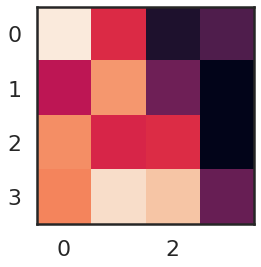

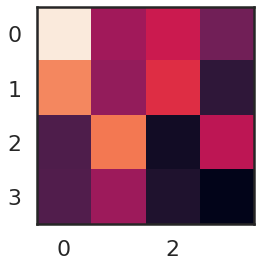

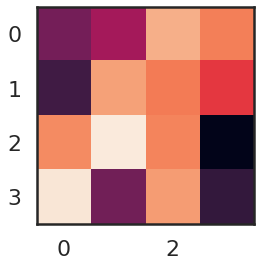

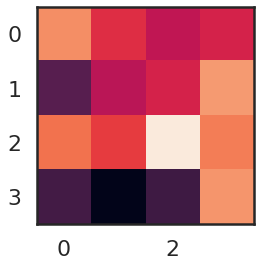

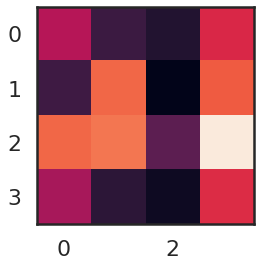

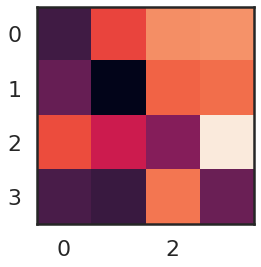

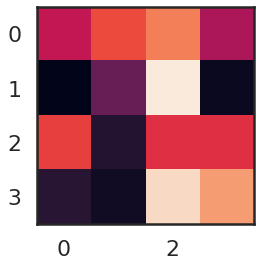

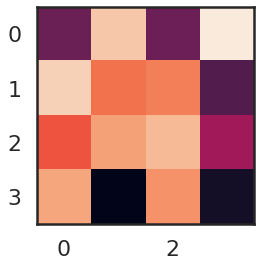

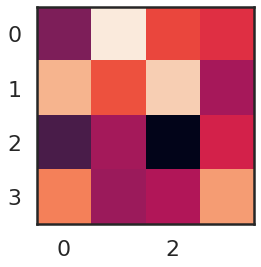

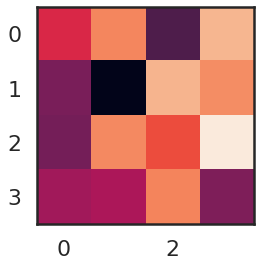

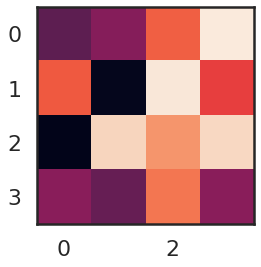

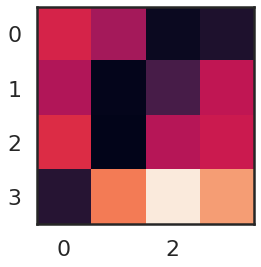

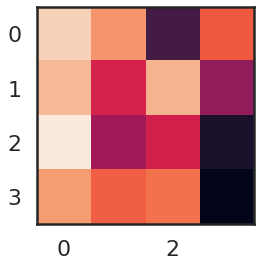

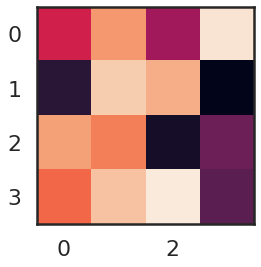

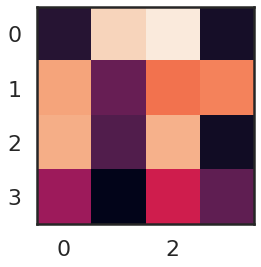

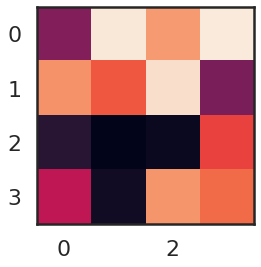

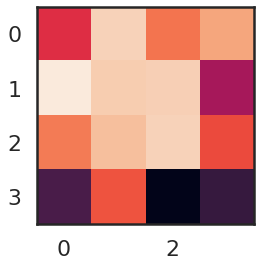

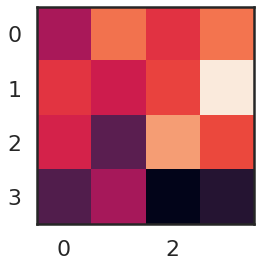

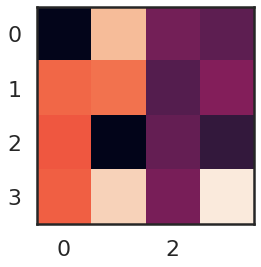

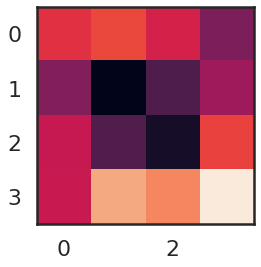

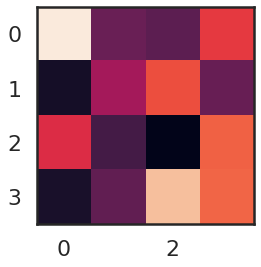

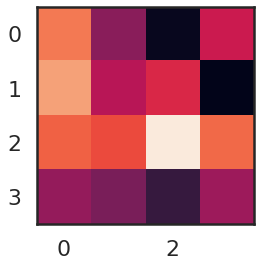

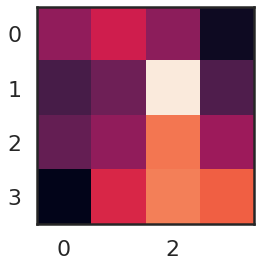

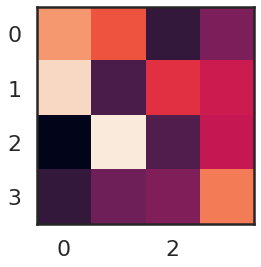

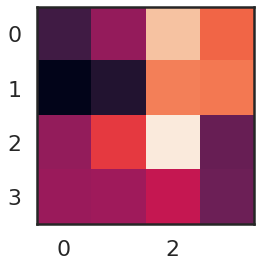

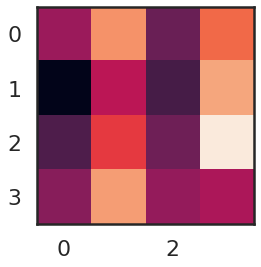

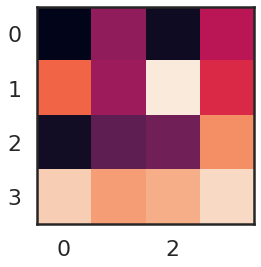

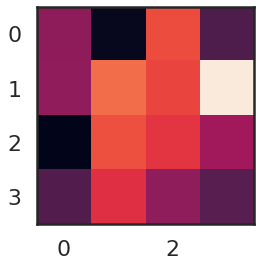

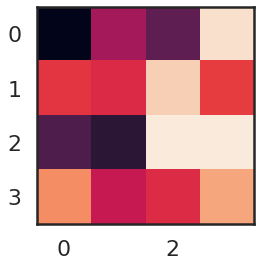

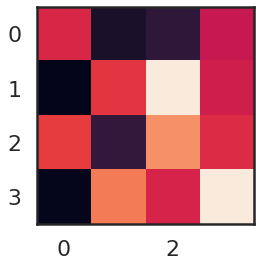

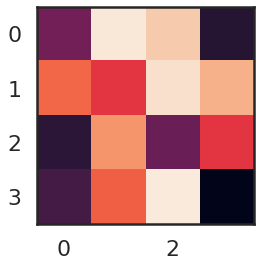

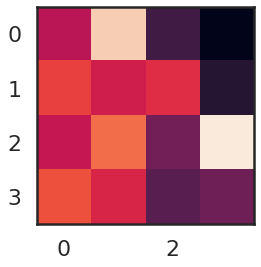

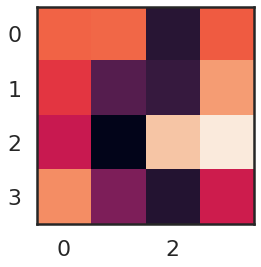

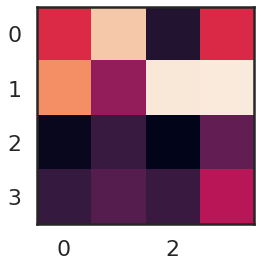

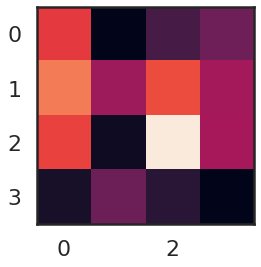

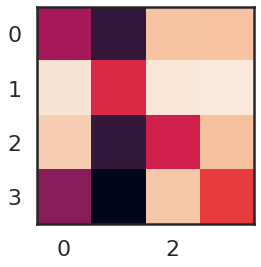

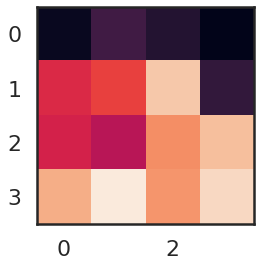

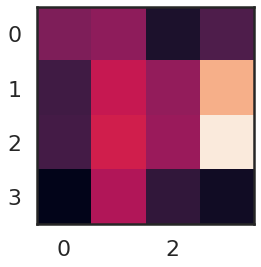

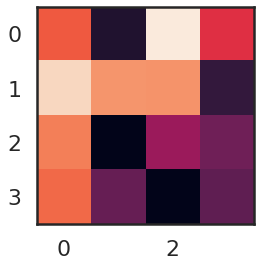

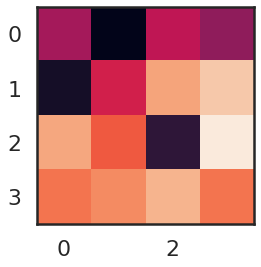

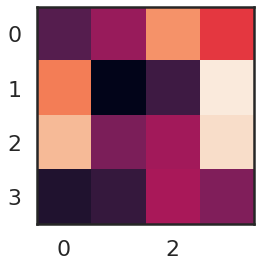

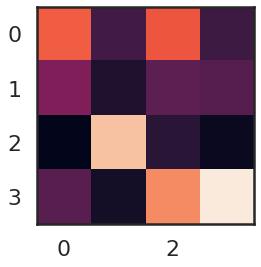

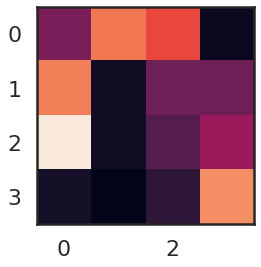

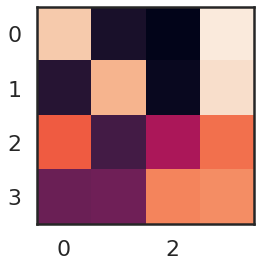

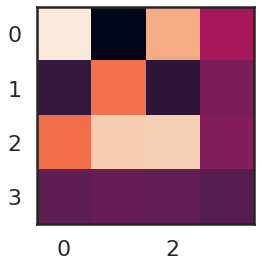

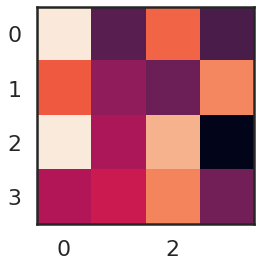

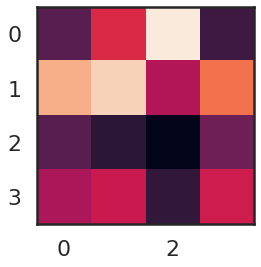

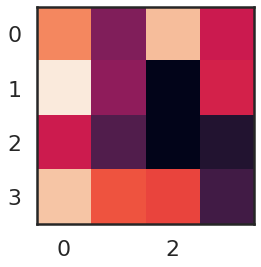

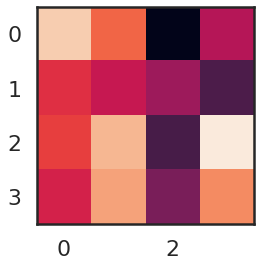

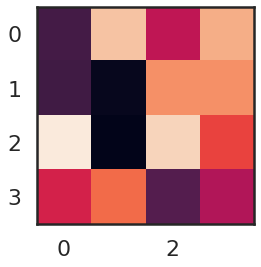

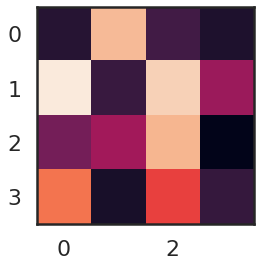

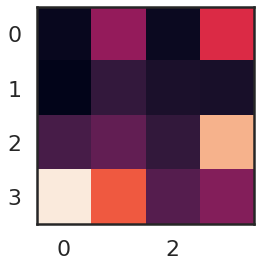

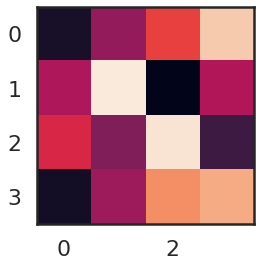

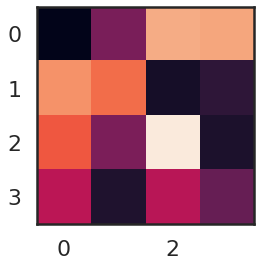

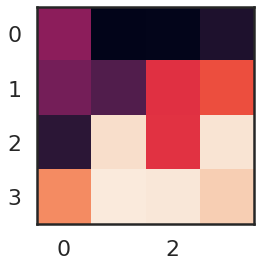

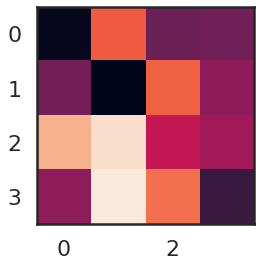

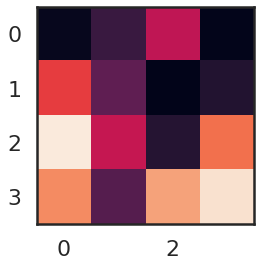

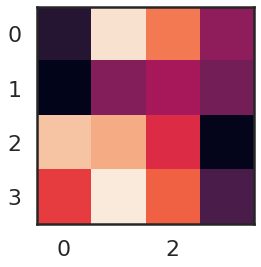

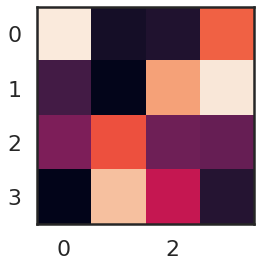

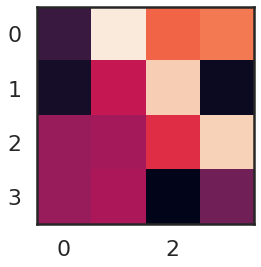

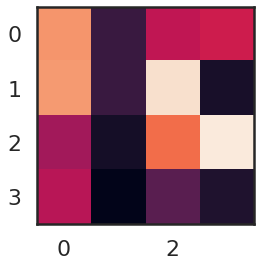

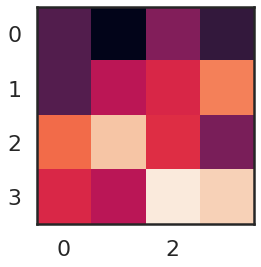

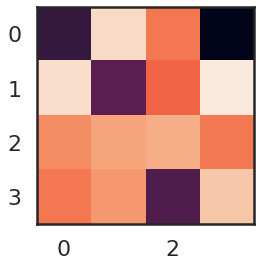

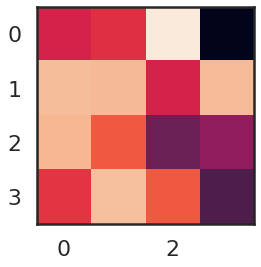

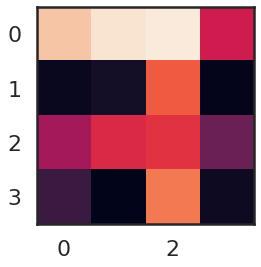

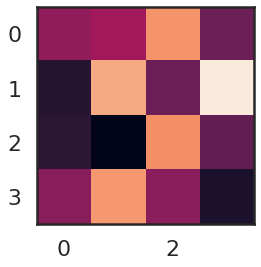

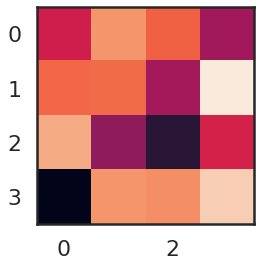

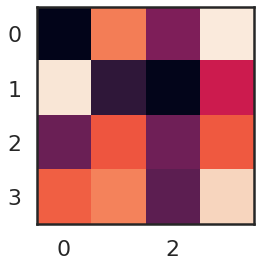

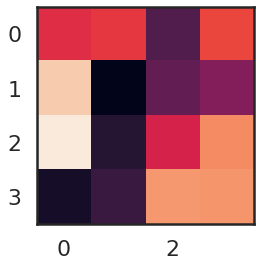

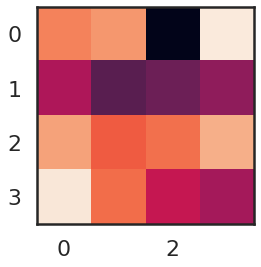

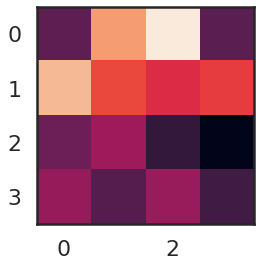

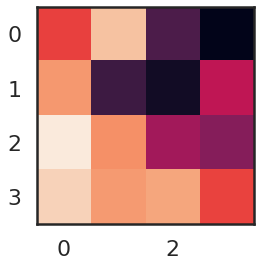

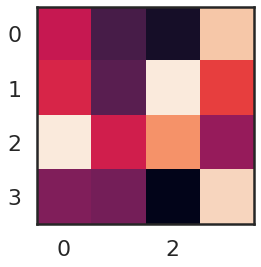

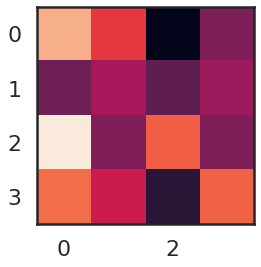

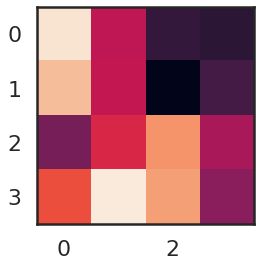

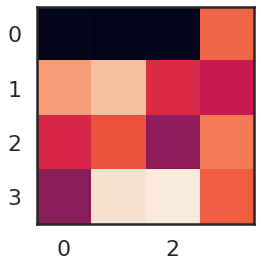

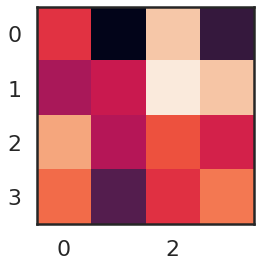

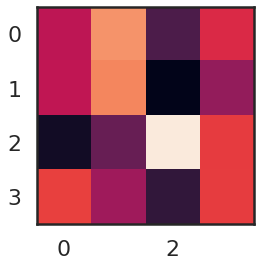

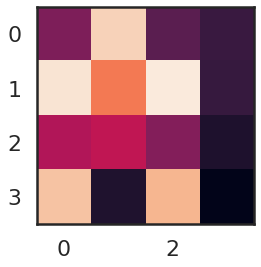

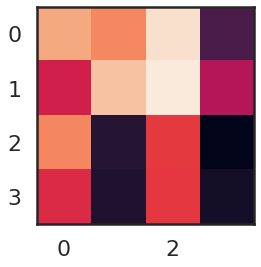

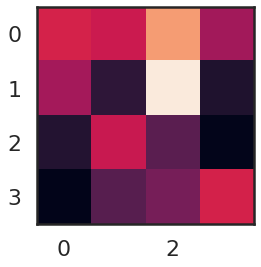

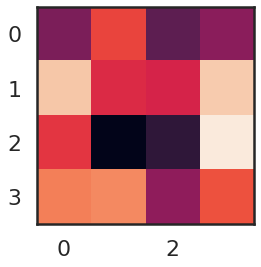

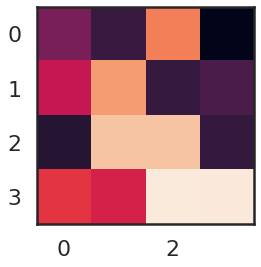

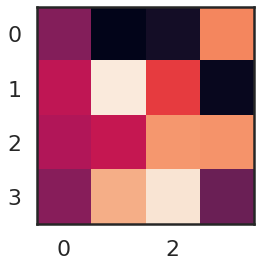

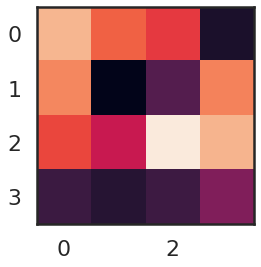

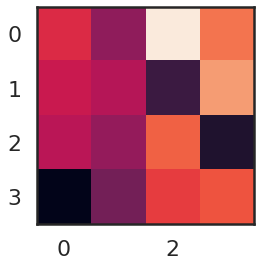

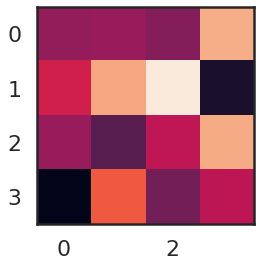

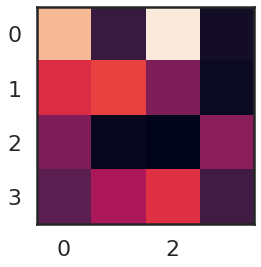

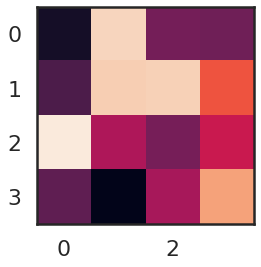

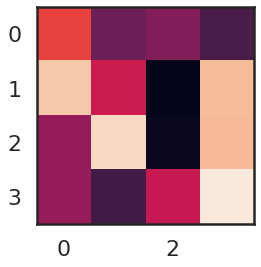

In [91]:
layer = net.conv1
layer = layer.weight.detach().cpu().numpy()

for l in layer:
    for k in l: 
        plt.figure()
        plt.imshow(k)

In [83]:
torch.re(net.conv1.weight.detach(), 0).shape

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [66]:
loader = DataLoader(test_loader.dataset, batch_size = 1, shuffle = True, num_workers=4)
n = 2


inhibiteds = []
not_inhibiteds = []

for i, (x, data, labels) in enumerate(loader):
    masks, hiddens, ior, selects_x = runner.visualize(x, data, labels)
    x = x.detach().cpu().numpy()
    
    inhibited = 0
    not_inhibited = 0
    
    for k in range(n):
        mask = masks[k]
        hidden = hiddens[k]
        selectx = selects_x[k]
        
        targethidden = ((x - selectx + 0.000001) / (x + 0.000001)) / strength
        targethidden = (targethidden > 0.5)
        
        inhibited += np.mean(hidden[targethidden])
        not_inhibited += np.mean(hidden[np.logical_not(targethidden)])
    
    inhibiteds.append(inhibited / n)
    not_inhibiteds.append(not_inhibited / n)
    
    if i % int(len(loader) / 30) == 0: 
        print(i)
    

0
27
54
81
108
135
162
189
216
243
270
297
324
351
378
405
432
459
486
513
540
567
594
621
648
675
702
729
756
783
810


In [67]:
values = inhibiteds + not_inhibiteds
labels = ["Not Attended"]*len(inhibiteds) + ["Attended"]*len(not_inhibiteds)
df = pd.DataFrame({"inhibition": values, "condition": labels})

In [73]:
# df.to_csv("inhibition_score_coco.csv")

In [77]:
df = pd.read_csv("inhibition_score_coco.csv")

In [68]:
colors = ["#d44e4e", "#0e4db3"]
sns.set_palette(sns.color_palette(colors))

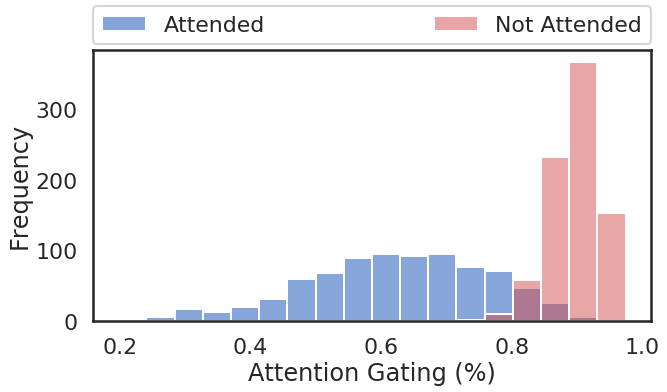

In [69]:
plt.figure(figsize=(10, 5))
sns.set_style("white")
sns.set_context("poster")
sns.histplot(data = df, x = "inhibition", hue="condition")
plt.ylabel("Frequency")
plt.xlabel("Attention Gating (%)")
plt.legend(["Attended", "Not Attended"], bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
# plt.legend()

In [76]:
df.groupby("condition")[["inhibition"]].mean()

,inhibition
condition,
Attended,0.111350
Not Attended,0.907287


In [75]:
df.groupby("condition")[["inhibition"]].std()

,inhibition
condition,
Attended,0.029267
Not Attended,0.011139


In [78]:
stat, p = ttest_rel(inhibiteds, not_inhibiteds)
print("\tT Statistic %s\tP Value: %s"%(stat, p))

	T Statistic 50.69279938948715	P Value: 4.524819405210929e-255
